# Binned fit with hist PDF

In [1]:
import os
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

def set_style(tick_label_size=16, font_size=18):
    import matplotlib
    matplotlib.rc('xtick', labelsize=tick_label_size)
    matplotlib.rc('ytick', labelsize=tick_label_size)
    matplotlib.rc('font', size=font_size)

set_style()

In [2]:
from lib.params import mdn

In [3]:
data_path = './mcsamples'

In [4]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd[mask], 0, None) * mdn * 10**3)
    return np.column_stack([e[mask], pd, np.sqrt(md1pisq[mask])])

In [5]:
def smeared_sample(gsre, gsim, chunks, N=-1, silent=True):
    fname = os.path.join(data_path, f'mc_ddpip_3d_gs{gsre:.2f}_{gsim:.2f}_ch{chunks}_smeared.npy')
    if not silent:
        print(fname)
    return get_vars(np.load(fname)[:N]) if os.path.isfile(fname) else None

In [6]:
def binned_smeared_sample(gsre, gsim, chunks, bins, rng, N=-1):
    smpl = smeared_sample(gsre, gsim, chunks, N)
    if smpl is None:
        return None
    return np.histogramdd(smpl, bins=bins, range=edges)[0]

In [7]:
def make_reference(gsre, gsim, bins, rng):
    hist = binned_smeared_sample(gsre, gsim, chunks=250, bins=bins, rng=rng)
    if hist is None:
        return None
    return hist / np.sum(hist)

In [8]:
gsre0, gsim0, chunks0 = 41, 1.5, 50
test_sample = smeared_sample(gsre0, gsim0, chunks0)
test_sample.shape

(61894, 3)

In [9]:
test_sample[:5]

array([[-1.8318750e-01,  3.9051517e+01,  2.0085833e+00],
       [ 5.6085639e-02,  4.4605392e+01,  2.0094507e+00],
       [ 2.0143719e+00,  8.3349091e+01,  2.0103295e+00],
       [ 4.0795660e+00,  6.2979267e+01,  2.0127962e+00],
       [ 2.4006266e-02,  2.5311789e+01,  2.0091407e+00]], dtype=float32)

In [10]:
def draw_1d_projections(ax, data, bins, rng, weights=None):
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for i in range(3):
        ax[i].hist(data[:,i], bins=bins[i], range=rng[i], weights=weights)
        ax[i].set_xlim(rng[i])
        ax[i].grid()
        ax[i].set_xlabel(labels[i])

In [11]:
bins = (20, 10, 10)
edges = ((-1.5, 8.), (0, 120), (2.006, 2.014))

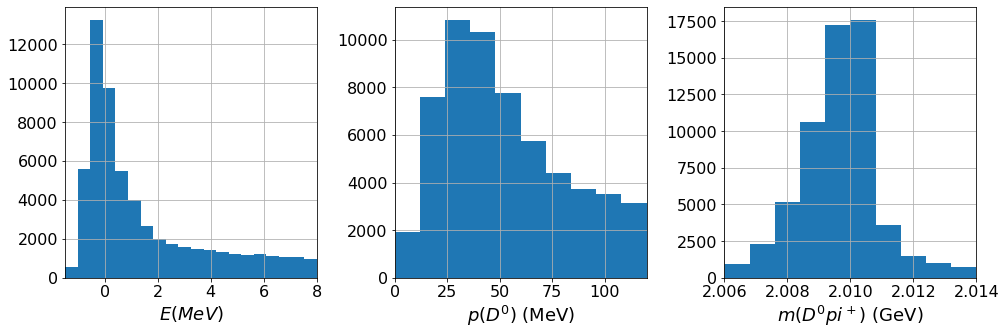

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(14,5))
draw_1d_projections(ax, test_sample, bins=bins, rng=edges)
fig.tight_layout()

In [13]:
sample = binned_smeared_sample(gsre0, gsim0, chunks0, bins, edges, N=5*10**4)

In [14]:
sample.shape

(20, 10, 10)

In [15]:
np.sum(sample)

45064.0

Most bins are empty

In [16]:
np.sum(sample==0), np.sum(sample!=0)

(1154, 846)

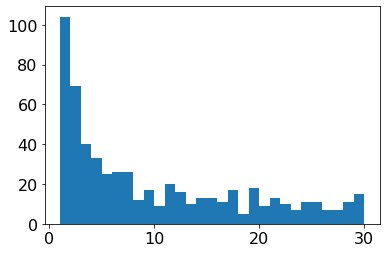

In [17]:
plt.hist(sample.flatten(), bins=29, range=(1, 30));

Chi2 fit cannot be used since most of bins contain zero or only a few events. Let't construct the binned likelihood function

$$
{\cal L} = \prod_i \frac{\mu_i^{n_i}e^{-\mu_i}}{n_i!}
$$

$$
{\cal F} = -\ln{\cal L}=-\sum_i\left(n_i\ln \mu_i - \mu_i - \ln (n_i!)\right)
$$

Second term in sum gives number of events in a tested sample $N$. The last term doesn't independ on the test sample, but we keep it in order to compare different reference probability densities.

$$
{\cal F} = -\sum_i\left(n_i\ln \mu_i - \ln (n_i!)\right) + N
$$

In [18]:
from scipy.special import loggamma

In [19]:
def binned_loglh(hist, ref_hist):
    """ Binned log likelihood function """
    mask = ref_hist > 0
    n = hist[mask]
    n[n == 0] = 1
    N = np.sum(n)
    mu = ref_hist[mask] / np.sum(ref_hist) * N
    return -np.sum(n * np.log(mu) - loggamma(n)) + N

In [20]:
gsrel = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
gsiml = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]

In [21]:
mg_gsre, mg_gsim = np.meshgrid(gsrel, gsiml)
mg_gsre.shape

(9, 12)

In [22]:
def make_lhmap(samp, gsre, gsim, bins, rng, subtract_min=True):
    """ """
    lhmap = np.empty(gsre.shape)
    for i in range(lhmap.shape[0]):
        for j in range(lhmap.shape[1]):
            reference = make_reference(gsre[i,j], gsim[i,j], bins, rng)
            if reference is None:
                print(f'reference not found for {mg_gsre[i,j]} {mg_gsim[i,j]}')
                lhmap[i,j] = -1
                continue
            lhmap[i,j] = binned_loglh(samp, reference)
    if subtract_min:
        lhmap -= np.min(lhmap)
    return lhmap

In [23]:
lhmap = make_lhmap(sample, mg_gsre, mg_gsim, bins, edges, subtract_min=True)

In [42]:
def draw_spline_contours(ax, x, y, z, levels=10):
#     f = interpolate.interp2d(x, y, z, kind='cubic')
    f = interpolate.interp2d(x, y, z, kind='linear')
    newx = np.linspace(np.min(x), np.max(x), 50)
    newy = np.linspace(np.min(y), np.max(y), 50)
    cntf = ax.contourf(newx, newy, f(newx, newy), levels=levels);
    plt.colorbar(cntf, ax=ax);

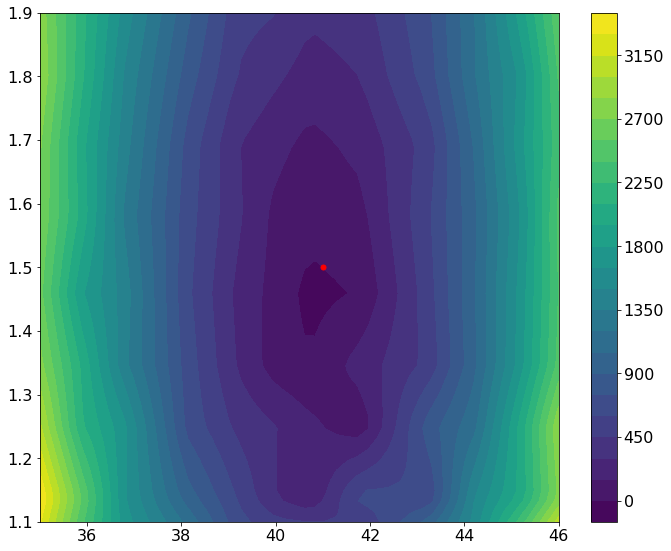

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
draw_spline_contours(ax, mg_gsre, mg_gsim, lhmap, levels=25)
ax.plot([41], [1.5], marker='.', markersize=10, color='r');
fig.tight_layout()

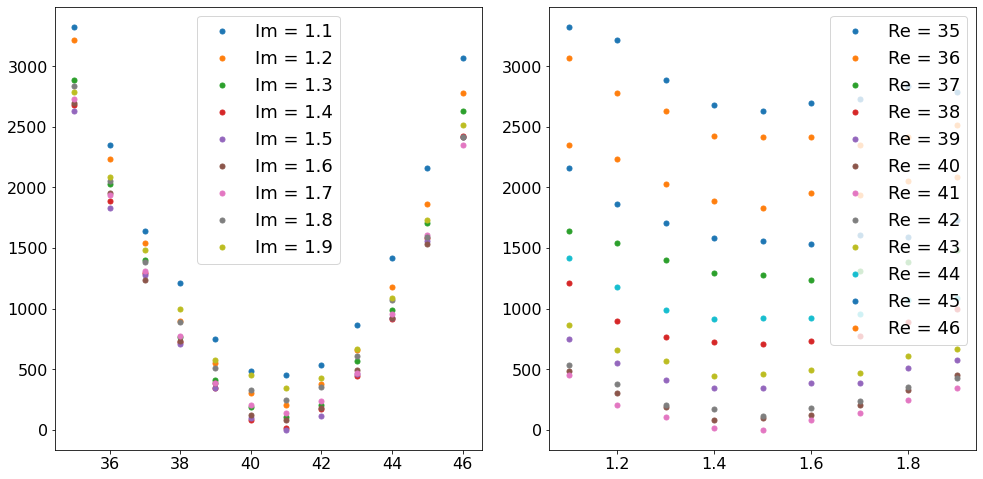

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
for i in range(lhmap.shape[0]):
    ax[0].plot(gsrel, lhmap[i,:], linestyle='none', marker='.', markersize=10, label=f'Im = {gsiml[i]}')
    ax[0].legend()

for j in range(lhmap.shape[1]):
    ax[1].plot(gsiml, lhmap[:,j], linestyle='none', marker='.', markersize=10, label=f'Re = {gsrel[j]}');
    ax[1].legend()

fig.tight_layout()

Estimate of the statistical precision

In [27]:
lhmap.shape

(9, 12)

In [28]:
ilo, ihi = 1, 7
jlo, jhi = 5, 8
lhmap[ilo:ihi,jlo:jhi] - np.min(lhmap[ilo:ihi,jlo:jhi])

array([[301.87456885, 206.70328442, 376.58531173],
       [186.23083939, 104.56029952, 200.22927499],
       [ 79.44427461,  15.74069652, 171.87446303],
       [ 94.59024819,   0.        , 111.80607482],
       [120.39424943,  77.6768549 , 177.34575495],
       [200.96111393, 134.00843499, 240.04873353]])

In [29]:
def parab(x, y, x0, y0, a, b, rho):
    """ """
    rot = np.array([
        [np.sqrt(1. - rho**2), -rho],
        [rho, np.sqrt(1. - rho**2)]
    ])
    xpr = (x - x0) * rot[0,0] + (y - y0) * rot[0, 1]
    ypr = (x - x0) * rot[1,0] + (y - y0) * rot[1, 1]
    return (xpr / a)**2 + (ypr / b)**2

In [45]:
def plot_parab(ax, x0, y0, a, b, rho):
    x = np.linspace(x0 - 10*a, x0 + 10*a, 100)
    y = np.linspace(y0 - 10*b, y0 + 10*b, 100)
    xl, yl = np.meshgrid(x, y)
    z = lambda x, y: parab(x, y, x0, y0, a, b, rho)
    return ax.contourf(xl, yl, z(xl, yl), levels=10)

In [32]:
ilo, ihi = 2, -1
jlo, jhi = 2, -1
xfit, yfit = np.meshgrid(gsrel[ilo:ihi], gsiml[jlo:jhi])
zfit = lhmap[ilo:ihi,jlo:jhi] - np.min(lhmap[ilo:ihi,jlo:jhi])
xfit.shape, yfit.shape, zfit.shape

((6, 9), (6, 9), (6, 9))

In [33]:
xfit

array([[37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45],
       [37, 38, 39, 40, 41, 42, 43, 44, 45]])

In [34]:
yfit

array([[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3],
       [1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4],
       [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5],
       [1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6],
       [1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7],
       [1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8]])

In [35]:
zfit

array([[1403.39715584,  764.19226266,  407.66238245,  186.23083939,
         104.56029952,  200.22927499,  564.8144926 ,  987.89612947,
        1706.57937993],
       [1291.51307243,  723.52109893,  340.91623596,   79.44427461,
          15.74069652,  171.87446303,  444.40973024,  910.22334069,
        1580.47151358],
       [1275.75221909,  709.10019994,  346.63580696,   94.59024819,
           0.        ,  111.80607482,  462.66391463,  922.18790105,
        1554.941419  ],
       [1236.81467473,  729.15938055,  386.33781723,  120.39424943,
          77.6768549 ,  177.34575495,  490.38734723,  923.56247828,
        1534.60838696],
       [1308.71633698,  771.18432609,  384.76046051,  200.96111393,
         134.00843499,  240.04873353,  470.03940598,  953.33550485,
        1605.70288458],
       [1381.31186898,  887.00752245,  507.04759833,  327.25417555,
         245.9513327 ,  350.67051747,  607.83666366, 1071.33181784,
        1588.55449136]])

In [36]:
def loss(pars):
    x0, y0, a, b, rho = pars
    rho = max(min(rho, 0.99), -0.99)
    return np.sum((zfit - parab(xfit, yfit, x0, y0, a, b, rho))**2)

In [37]:
from scipy.optimize import minimize

In [38]:
init = (41, 1.5, 0.1, 0.1, 0.)
res = minimize(loss, init)
res

      fun: 185268.10027120274
 hess_inv: array([[ 1.37638915e-06,  8.58006578e-07, -3.02896548e-08,
         4.92407328e-08,  1.13295460e-06],
       [ 8.58006578e-07,  1.31189402e-05, -1.03742597e-06,
         1.37608314e-07,  5.75080900e-06],
       [-3.02896548e-08, -1.03742597e-06,  8.60440993e-08,
        -9.77760712e-09, -4.51998921e-07],
       [ 4.92407328e-08,  1.37608314e-07, -9.77760712e-09,
         2.74624272e-09,  8.45278846e-08],
       [ 1.13295460e-06,  5.75080900e-06, -4.51998921e-07,
         8.45278846e-08,  3.10858448e-06]])
      jac: array([-0.55664062,  0.09960938,  3.92578125, 16.73046875,  0.07617188])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 786
      nit: 87
     njev: 129
   status: 2
  success: False
        x: array([40.7118131 ,  0.62560966,  0.09336764, -0.11025434,  0.96101704])

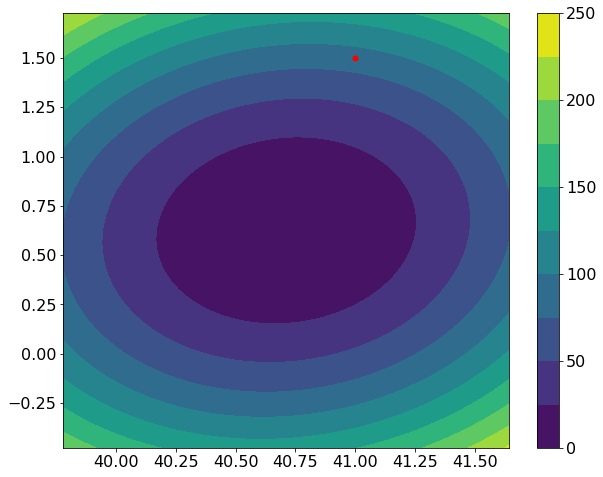

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
cnt = plot_parab(ax, *res.x)
ax.plot([41], [1.5], marker='.', markersize=10, color='r');
plt.colorbar(cnt);

In [47]:
covar = np.diagonal(res.hess_inv)
np.sqrt(covar)

array([1.17319612e-03, 3.62200775e-03, 2.93332745e-04, 5.24046059e-05,
       1.76311783e-03])

In [48]:
sigmas = np.sqrt(covar) * np.sqrt(5*10**4)
sigmas

array([0.26233463, 0.80990556, 0.0655912 , 0.01171803, 0.39424513])

In [49]:
print(f's(gamma_re) = {sigmas[0]*10**3:.1f} / 10^3 / sqrt(N) MeV')
print(f's(gamma_im) = {sigmas[1]*10**3:.1f} / 10^3 / sqrt(N) MeV')

s(gamma_re) = 262.3 / 10^3 / sqrt(N) MeV
s(gamma_im) = 809.9 / 10^3 / sqrt(N) MeV


In [50]:
nevents = 400
print(f's(gamma_re) = {sigmas[0]/np.sqrt(nevents)*10**3:.1f} / 10^3 MeV @ {nevents} events')
print(f's(gamma_im) = {sigmas[1]/np.sqrt(nevents)*10**3:.1f} / 10^3 MeV @ {nevents} events')

s(gamma_re) = 13.1 / 10^3 MeV @ 400 events
s(gamma_im) = 40.5 / 10^3 MeV @ 400 events
